In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import random
import re
from validation_functions import *
from numba import njit

plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 22
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

/tmp/ipykernel_971128/4211290353.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-deep')


In [2]:
def read_inf_coords(dim, path):
    df = pd.read_csv(path, sep="\s+", header=None, comment="#")
    if dim == 1:
        df.columns = ['index', 'inf_kappa', 'inf_theta', 'inf_radius']
    else:
        cols = [f'inf_p{i}' for i in range(dim+1)]
        df.columns = ['index', 'inf_kappa', 'inf_radius', *cols] # TODO: test it
    return df


def read_all_coordinates(dim ,folder):
    ### Coordinates to load:
    # 1. Inferred coordinates of nodes in unipartite
    # 2. Inferred coordinates of nodes in unipartite (after joint maximization likelihood (JML))
    # 3. Inferred coordinates of nodes in bipartite (after JML)
    # 4. Inferred coordinates of features in bipartite (after JML)
    # 5. Inferred coordinates of nodes in bipartite
    # 6. Inferred coordinates of features in bipartite
    inf_coord_files = glob.glob(f'{folder}/*inf_coord*')
    for file in inf_coord_files:
        if 'features_le' in file:
            inf_coord_features_le = read_inf_coords(dim, file)
        elif 'nodes_le' in file:
            inf_coord_nodes_le = read_inf_coords(dim, file)
        elif 'features' in file:
            inf_coord_features = read_inf_coords(dim, file)
        elif 'nodes' in file:
            inf_coord_nodes = read_inf_coords(dim, file)
        elif '_raw' in file:
            ''
        elif 'coord_le' in file:
            inf_coord_le = read_inf_coords(dim, file)
        else:
            inf_coord = read_inf_coords(dim, file)
        
    # Merge inferred and generated coordinates
    # 1. Coordinates of nodes in unipartite
    # 2. Coordinates of nodes in bipartite
    # 3. Coordinates of features in bipartite
    df = inf_coord.merge(inf_coord_le, on='index', suffixes=('', '_le'))
    df_nodes = inf_coord_nodes.merge(inf_coord_nodes_le, on='index', suffixes=('', '_le'))
    df_features = inf_coord_features.merge(inf_coord_features_le, on='index', suffixes=('', '_le'))
    return df, df_nodes, df_features

In [3]:
p = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/webkb/texas/"

df_S1, df_nodes_S1, df_features_S1 = read_all_coordinates(1, f"{p}/eS1")
df_S2, df_nodes_S2, df_features_S2 = read_all_coordinates(2, f"{p}/eS2")
df_S3, df_nodes_S3, df_features_S3 = read_all_coordinates(3, f"{p}/eS3")
df_S4, df_nodes_S4, df_features_S4 = read_all_coordinates(4, f"{p}/eS4")

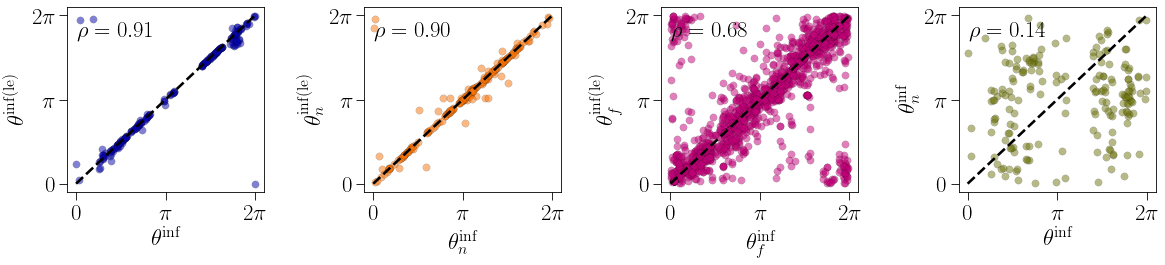

In [4]:
def plot_inf_corr_theta(df1, col1, df2, col2, color, xlabel, ylabel):
    df_merge = df1.merge(df2, on='index', suffixes=('_1', '_2'))
    plt.scatter(df_merge[f'{col1}_1'], df_merge[f'{col2}_2'], marker='.', color=color, edgecolors='black',
                lw=0.2, alpha=0.5)
    xx = np.linspace(0, 2*np.pi)
    plt.plot(xx, xx, linestyle='--', color='black')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks([0, np.pi, 2*np.pi], ['$0$', r'$\pi$', r'$2\pi$'])
    plt.yticks([0, np.pi, 2*np.pi], ['$0$', r'$\pi$', r'$2\pi$'])
    
    res = stats.pearsonr(df_merge[f'{col1}_1'], df_merge[f'{col2}_2']).statistic
    plt.text(0.05, 0.84, rf'$\rho={{{res:.2f}}}$', fontsize=22, transform=plt.gca().transAxes, color='black')


plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plot_inf_corr_theta(df_S1, 'inf_theta', df_S1, 'inf_theta_le', 
                    'xkcd:royal blue', r'$\theta^{\mathrm{inf}}$', r'$\theta^{\mathrm{inf(le)}}$')

plt.subplot(1, 4, 2)
plot_inf_corr_theta(df_nodes_S1, 'inf_theta', df_nodes_S1, 'inf_theta_le', 
                    'xkcd:orange', r'$\theta_n^{\mathrm{inf}}$', r'$\theta_n^{\mathrm{inf(le)}}$')

plt.subplot(1, 4, 3)
plot_inf_corr_theta(df_features_S1, 'inf_theta', df_features_S1, 'inf_theta_le', 
                    'xkcd:magenta', r'$\theta_f^{\mathrm{inf}}$', r'$\theta_f^{\mathrm{inf(le)}}$')

plt.subplot(1, 4, 4)
plot_inf_corr_theta(df_S1, 'inf_theta', df_nodes_S1, 'inf_theta', 
                    'xkcd:olive', r'$\theta^{\mathrm{inf}}$', r'$\theta_n^{\mathrm{inf}}$')

plt.tight_layout()
plt.show()

In [5]:
from cmcrameri import cm
# https://www.fabiocrameri.ch/ws/media-library/ce2eb6eee7c345f999e61c02e2733962/readme_scientificcolourmaps.pdf
# https://www.nature.com/articles/s41467-020-19160-7.pdf


@njit
def compute_angle(u, v):
    a = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    if a > 1:
        a = 1
    elif a < -1:
        a = -1
    return np.arccos(a)


@njit
def fast_compute_distances(x1, x2):
    distances = []
    for i in range(len(x1)):
        for j in range(i):
            d1 = compute_angle(x1[i], x1[j])
            d2 = compute_angle(x2[i], x2[j])
            distances.append([d1, d2])
    return np.array(distances)
    

@njit
def fast_compute_distances_dim1(x1, x2):
    distances = []
    for i in range(len(x1)):
        for j in range(i):
            d1 = np.pi - np.fabs(np.pi - np.fabs(x1[i] - x1[j]))
            d2 = np.pi - np.fabs(np.pi - np.fabs(x2[i] - x2[j]))
            distances.append([d1, d2])
    return np.array(distances)
    
    
def compute_distances(df1, cols1, df2, cols2, dim):
    df_merge = df1.merge(df2, on='index', suffixes=('_1', '_2'))

    if dim == 1:
        x1 = df_merge[f'{cols1}_1'].values
        x2 = df_merge[f'{cols2}_2'].values
    else:
        x1 = df_merge[[f'{col}_1' for col in cols1]].values
        x2 = df_merge[[f'{col}_2' for col in cols2]].values
        
    # for larger networks it can be slow, sample 2k random nodes or features
    max_size = 2000
    if len(x1) > max_size:
        tmp_sub = np.random.choice(np.arange(len(x1)), size=max_size, replace=False)
        x1 = x1[tmp_sub]
        x2 = x2[tmp_sub]

    if dim == 1:
        distances = fast_compute_distances_dim1(x1, x2)
    else:
        distances = fast_compute_distances(x1, x2)
    return distances


def get_inverse_g_value(rho):
    # Fitted values obtained from synthetic networks
    a = 2.43
    b = 1.4
    g = 1 / a * np.log(1/rho - 1) + b
    return np.clip(g, 0, np.pi) # 0 - perfect correlation, pi - luck of correlation


def plot_angle_comparison(df1, cols1, df2, cols2, ax, xlabel, ylabel, dim=1):
    distances = compute_distances(df1, cols1, df2, cols2, dim)
    heatmap, xedges, yedges = np.histogram2d(distances[:, 0], distances[:, 1], bins=(50, 50))
    cax = ax.imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    origin='lower', aspect='auto', cmap=cm.lipari_r)
    ax.set_xticks([0, np.pi/2, np.pi])
    ax.set_yticks([0, np.pi/2, np.pi])
    ax.set_xticklabels(['$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    ax.set_yticklabels(['$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    res = stats.pearsonr(distances[:, 0], distances[:, 1]).statistic
    ax.text(0.05, 0.84, rf'$\rho={{{res:.2f}}}$', fontsize=22, transform=ax.transAxes, color='black')
    g = get_inverse_g_value(res)
    ax.text(0.05, 0.74, rf'$g={{{g:.2f}}}$', fontsize=22, transform=ax.transAxes, color='black')

CPU times: user 912 ms, sys: 294 ms, total: 1.21 s
Wall time: 1.71 s


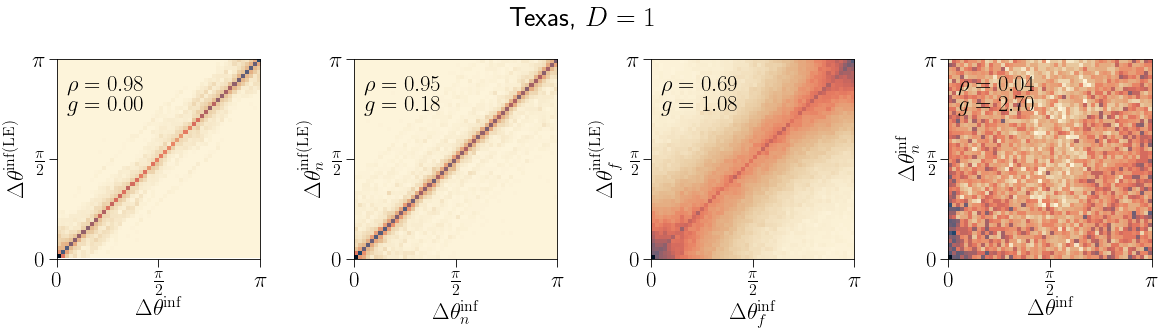

In [7]:
%%time

fig, axs = plt.subplots(1, 4, figsize=(16, 5))

dim = 1
xlabs = 'inf_theta'
ylabs = 'inf_theta_le'

plot_angle_comparison(df_S1, xlabs, df_S1, ylabs, axs[0],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta^{\mathrm{inf(LE)}}$')

plot_angle_comparison(df_nodes_S1, xlabs, df_nodes_S1, ylabs, axs[1],
                      r'$\Delta\theta_n^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf(LE)}}$')

plot_angle_comparison(df_features_S1, xlabs, df_features_S1, ylabs, axs[2],
                      r'$\Delta\theta_f^{\mathrm{inf}}$', r'$\Delta\theta_f^{\mathrm{inf(LE)}}$')

plot_angle_comparison(df_S1, xlabs, df_nodes_S1, ylabs, axs[3],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf}}$')

plt.suptitle(rf'Texas, $D={dim}$', y=0.92)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/f-mercator-real-networks-examples-31-07-24/plots/texas_dim1.pdf")


/tmp/ipykernel_971128/1534976427.py:21: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  d1 = compute_angle(x1[i], x1[j])


CPU times: user 2.81 s, sys: 222 ms, total: 3.03 s
Wall time: 7.57 s


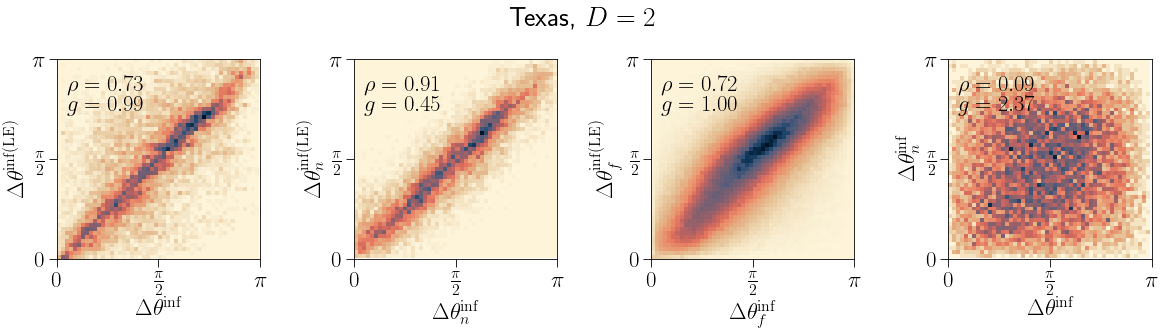

In [8]:
%%time

fig, axs = plt.subplots(1, 4, figsize=(16, 5))

dim = 2
xlabs = [f'inf_p{d}' for d in range(dim+1)]
ylabs = [f'inf_p{d}_le' for d in range(dim+1)]

plot_angle_comparison(df_S2, xlabs, df_S2, ylabs, axs[0],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta^{\mathrm{inf(LE)}}$', dim=2)

plot_angle_comparison(df_nodes_S2, xlabs, df_nodes_S2, ylabs, axs[1],
                      r'$\Delta\theta_n^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf(LE)}}$', dim=2)

plot_angle_comparison(df_features_S2, xlabs, df_features_S2, ylabs, axs[2],
                      r'$\Delta\theta_f^{\mathrm{inf}}$', r'$\Delta\theta_f^{\mathrm{inf(LE)}}$', dim=2)

plot_angle_comparison(df_S2, xlabs, df_nodes_S2, ylabs, axs[3],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf}}$', dim=2)

plt.suptitle(rf'Texas, $D={dim}$', y=0.92)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/f-mercator-real-networks-examples-31-07-24/plots/texas_dim2.pdf")


CPU times: user 1.91 s, sys: 339 ms, total: 2.25 s
Wall time: 8.37 s


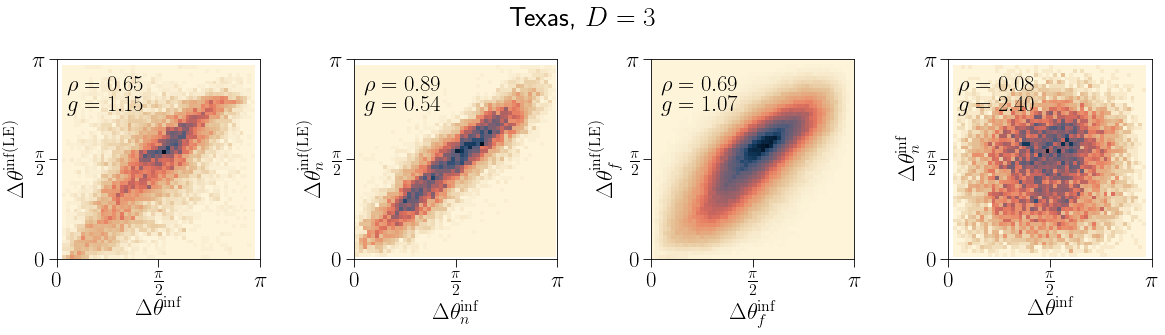

In [9]:
%%time

fig, axs = plt.subplots(1, 4, figsize=(16, 5))

dim = 3
xlabs = [f'inf_p{d}' for d in range(dim+1)]
ylabs = [f'inf_p{d}_le' for d in range(dim+1)]

plot_angle_comparison(df_S3, xlabs, df_S3, ylabs, axs[0],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta^{\mathrm{inf(LE)}}$', dim=dim)

plot_angle_comparison(df_nodes_S3, xlabs, df_nodes_S3, ylabs, axs[1],
                      r'$\Delta\theta_n^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf(LE)}}$', dim=dim)

plot_angle_comparison(df_features_S3, xlabs, df_features_S3, ylabs, axs[2],
                      r'$\Delta\theta_f^{\mathrm{inf}}$', r'$\Delta\theta_f^{\mathrm{inf(LE)}}$', dim=dim)

plot_angle_comparison(df_S3, xlabs, df_nodes_S3, ylabs, axs[3],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf}}$', dim=dim)

plt.suptitle(rf'Texas, $D={dim}$', y=0.92)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/f-mercator-real-networks-examples-31-07-24/plots/texas_dim3.pdf")


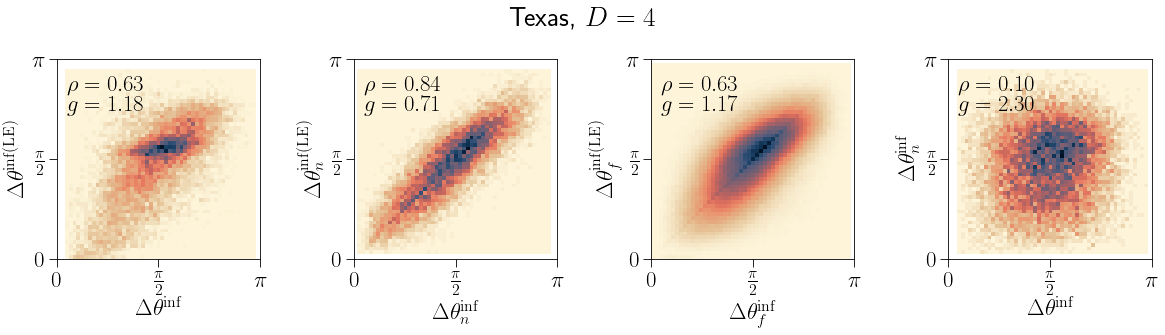

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

dim = 4
xlabs = [f'inf_p{d}' for d in range(dim+1)]
ylabs = [f'inf_p{d}_le' for d in range(dim+1)]

plot_angle_comparison(df_S4, xlabs, df_S4, ylabs, axs[0],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta^{\mathrm{inf(LE)}}$', dim=dim)

plot_angle_comparison(df_nodes_S4, xlabs, df_nodes_S4, ylabs, axs[1],
                      r'$\Delta\theta_n^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf(LE)}}$', dim=dim)

plot_angle_comparison(df_features_S4, xlabs, df_features_S4, ylabs, axs[2],
                      r'$\Delta\theta_f^{\mathrm{inf}}$', r'$\Delta\theta_f^{\mathrm{inf(LE)}}$', dim=dim)

plot_angle_comparison(df_S4, xlabs, df_nodes_S4, ylabs, axs[3],
                      r'$\Delta\theta^{\mathrm{inf}}$', r'$\Delta\theta_n^{\mathrm{inf}}$', dim=dim)

plt.suptitle(rf'Texas, $D={dim}$', y=0.92)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/f-mercator-real-networks-examples-31-07-24/plots/texas_dim4.pdf")



Compare coordinates from F-Mercator and D-Mercator (unipartite network)

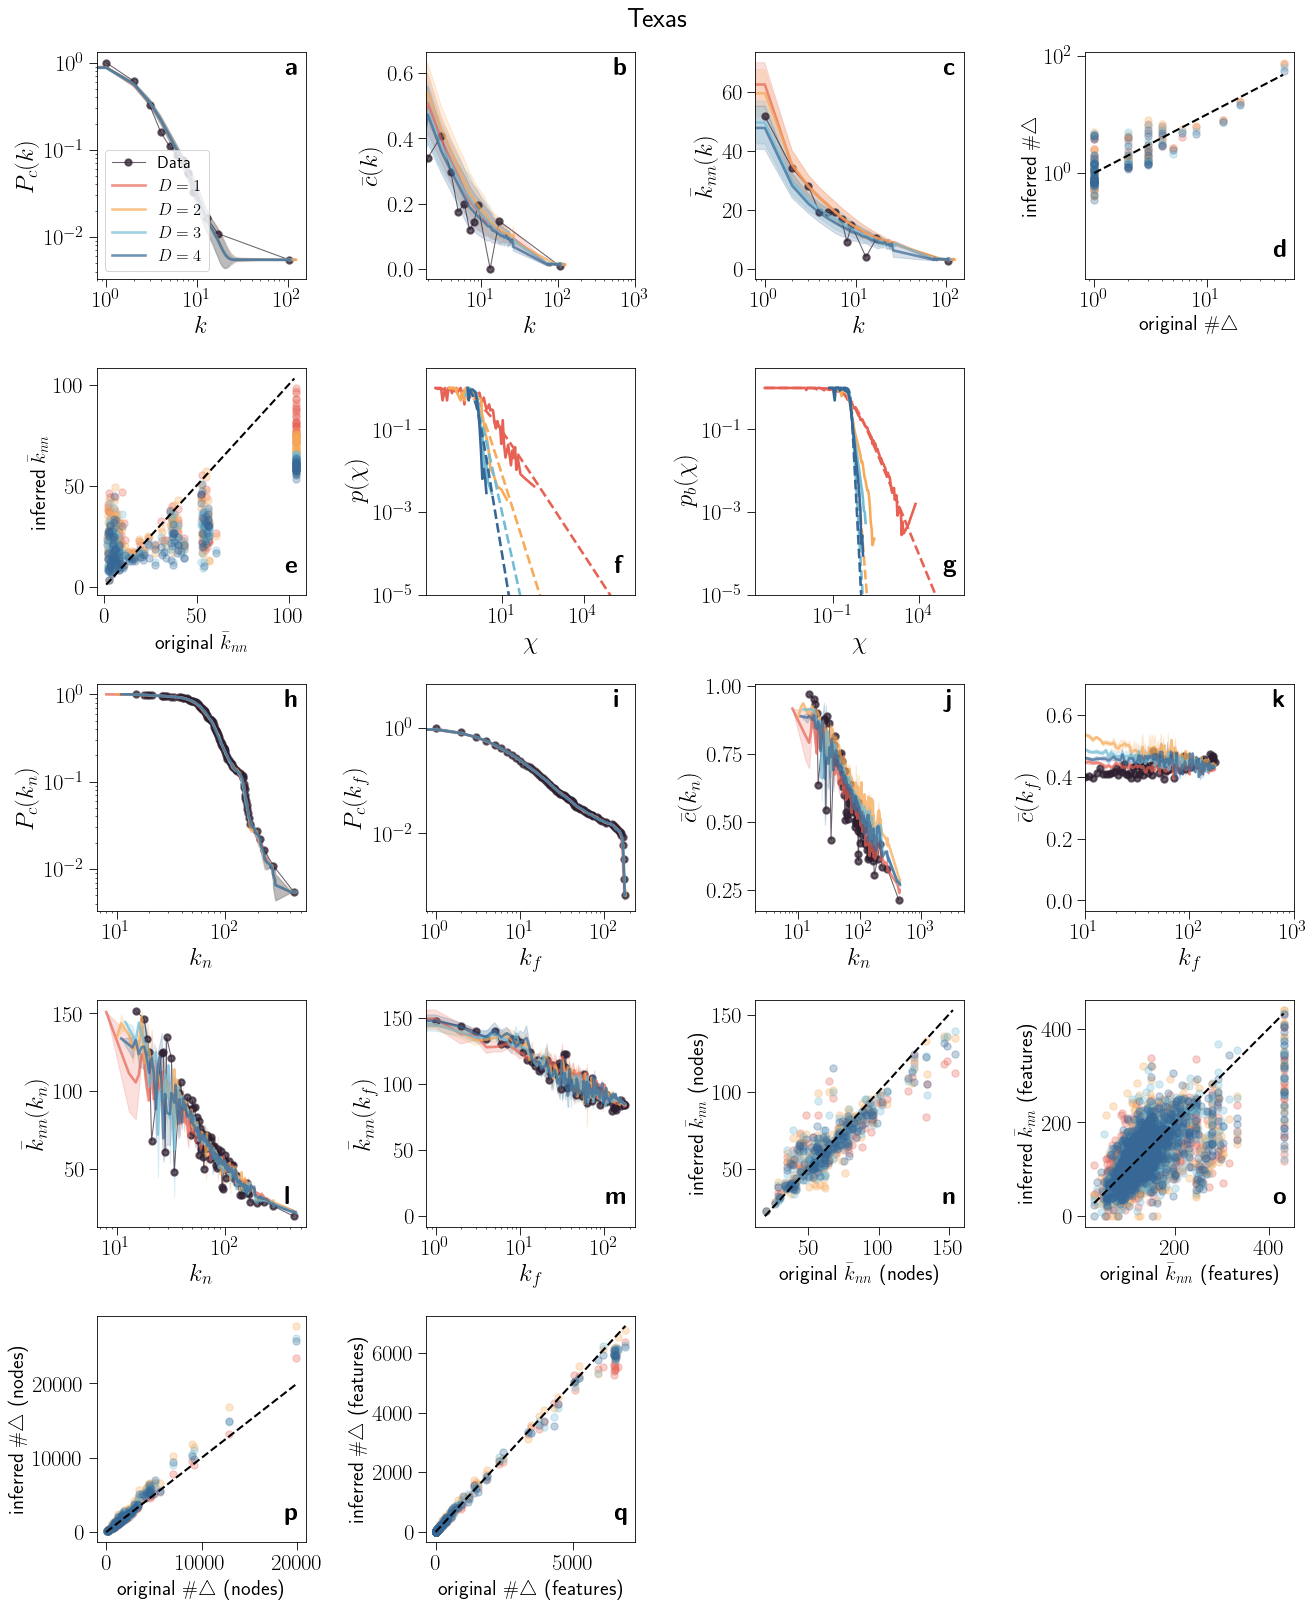

In [11]:
base_path = '/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/webkb/texas/'

filename = 'out1_graph_edges'

paths = [f"{base_path}/eS{d}" for d in [1, 2, 3, 4]]
labels = [rf'$D={d}$' for d in [1, 2, 3, 4]]

# Unipartite
dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(paths[0], filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

# Bipartite

dfs_vstats_bipartite_nodes = [load_vstats_bipartite_nodes(p, filename) for p in paths]
dfs_vstats_bipartite_features = [load_vstats_bipartite_features(p, filename) for p in paths]

df_vprop_bipartite_nodes = [load_vprops_bipartite_nodes(p, filename) for p in paths]
df_vprop_bipartite_features = [load_vprops_bipartite_features(p, filename) for p in paths]

df_obs_bipartite_nodes = load_vstat_obs_bipartite_nodes(paths[0], filename)
df_obs_bipartite_features = load_vstat_obs_bipartite_features(paths[0], filename)
df_pconns_bipartite = [load_bipartite_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(18, 22))
plt.subplot(5, 4, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(loc='lower left', fontsize=16)
plt.text(0.9, 0.9, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.xlim(1.9, 1000)
plt.text(0.9, 0.9, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 3)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.text(0.9, 0.9, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 4)
plot_number_of_triangles(df_vprop, labels)
plt.text(0.9, 0.1, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 5)
plot_sum_degree_neighbours(df_vprop, labels, log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{e}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 6)
plot_connection_probabilities(df_pconns, labels)
plt.text(0.9, 0.1, r'$\textbf{f}$', fontsize=24, transform=plt.gca().transAxes)

## Bipartite-S1
plt.subplot(5, 4, 7)
plot_connection_probabilities(df_pconns_bipartite, labels, ylabel=r'$p_b(\chi)$')
plt.text(0.9, 0.1, r'$\textbf{g}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 9)
plot_degree_distribution(df_obs_bipartite_nodes, dfs_vstats_bipartite_nodes, labels, xlabel=r'$k_n$',
                         ylabel=r'$P_c(k_n)$')
plt.text(0.9, 0.9, r'$\textbf{h}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 10)
plot_degree_distribution(df_obs_bipartite_features, dfs_vstats_bipartite_features, labels, xlabel=r'$k_f$',
                         ylabel=r'$P_c(k_f)$')
plt.text(0.9, 0.9, r'$\textbf{i}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 11)
plot_clustering_coefficient(df_obs_bipartite_nodes, dfs_vstats_bipartite_nodes, labels, xlabel=r'$k_n$',
                         ylabel=r'$\bar{c}(k_n)$')
plt.xlim(2, 5000)
plt.text(0.9, 0.9, r'$\textbf{j}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 12)
plot_clustering_coefficient(df_obs_bipartite_features, dfs_vstats_bipartite_features, labels, xlabel=r'$k_f$',
                         ylabel=r'$\bar{c}(k_f)$')
plt.xlim(10, 1000)
plt.text(0.9, 0.9, r'$\textbf{k}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 13)
plot_average_degree_neighbour(df_obs_bipartite_nodes, dfs_vstats_bipartite_nodes, labels,
                              xlabel=r'$k_n$', ylabel=r"$\bar{k}_{nn}(k_n)$")
plt.text(0.9, 0.1, r'$\textbf{l}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 14)
plot_average_degree_neighbour(df_obs_bipartite_features, dfs_vstats_bipartite_features, labels,
                              xlabel=r'$k_f$', ylabel=r"$\bar{k}_{nn}(k_f)$")
plt.text(0.86, 0.1, r'$\textbf{m}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 15)
plot_sum_degree_neighbours(df_vprop_bipartite_nodes, labels, additional_label=' (nodes)', 
                           log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{n}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 16)
plot_sum_degree_neighbours(df_vprop_bipartite_features, labels, additional_label=' (features)',
                           log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{o}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 17)
plot_number_of_triangles(df_vprop_bipartite_nodes, labels, additional_label=' (nodes)', 
                         log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{p}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(5, 4, 18)
plot_number_of_triangles(df_vprop_bipartite_features, labels, additional_label=' (features)', 
                         log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{q}$', fontsize=24, transform=plt.gca().transAxes)

plt.suptitle(r'Texas', y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/f-mercator-real-networks-examples-31-07-24/plots/texas_topological_properties.png", dpi=300)


In [13]:
df_labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/webkb/texas/out1_node_feature_label.labels", sep="\t", header=None)
df_labels.columns = ['index', 'class']
df_labels.head()

,index,class
0,0,3
1,1,0
2,2,2
3,3,3
4,4,4


In [14]:
df_S1_merged = df_S1.merge(df_labels)
df_S1_merged.head()

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,class
0,0,4.71741,1.47540,19.5538,5.70674,1.47540,15.2143,3
1,1,1.27230,1.30687,22.1746,2.18930,1.30066,17.1305,0
2,2,2.11166,2.20151,21.1613,2.18930,2.20151,17.1305,2
3,3,1.35200,5.70366,22.0531,2.18930,5.38511,17.1305,3
4,4,7.72571,1.18557,18.5672,10.17710,1.22949,14.0573,4


In [15]:
df_nodes_S1_merged = df_nodes_S1.merge(df_labels)
df_nodes_S1_merged.head()

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,class
0,0,310.321,2.223730,15.8765,280.689,2.268930,16.0773,3
1,1,4885.120,0.299818,10.3638,4694.980,0.536726,10.4433,0
2,2,107.743,3.518300,17.9923,108.900,3.584240,17.9709,2
3,3,731.782,3.734000,14.1608,681.135,3.712720,14.3042,3
4,4,732.059,5.139190,14.1600,857.763,5.091830,13.8431,4


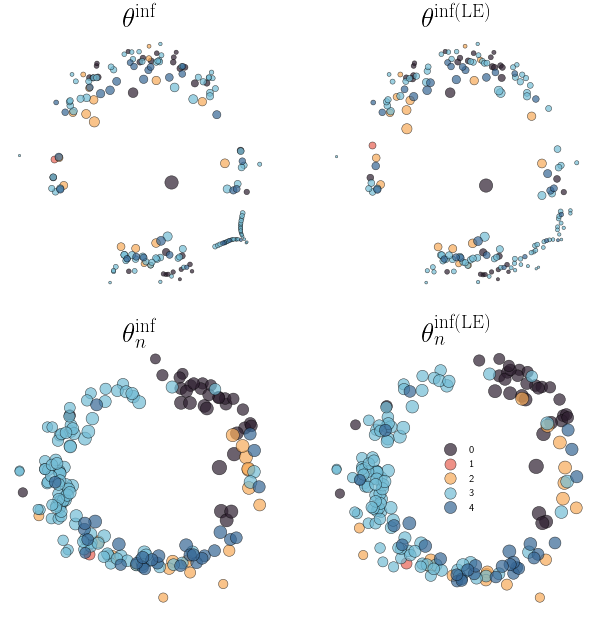

In [16]:
colormap = {label: color for color, label in zip(COLORS, np.unique(df_labels['class']))}

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for label, group in df_S1_merged.groupby('class'):
    group['x'] = group['inf_radius'] * np.cos(group['inf_theta'])
    group['y'] = group['inf_radius'] * np.sin(group['inf_theta'])    
    axs[0, 0].scatter(group['x'], group['y'], s=20*np.log(group['inf_kappa'] + 1), label=label, color=colormap[label], 
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)

    group['x'] = group['inf_radius'] * np.cos(group['inf_theta_le'])
    group['y'] = group['inf_radius'] * np.sin(group['inf_theta_le'])    
    axs[0, 1].scatter(group['x'], group['y'], s=20*np.log(group['inf_kappa'] + 1), label=label, color=colormap[label], 
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)


for label, group in df_nodes_S1_merged.groupby('class'):
    group['x'] = group['inf_radius'] * np.cos(group['inf_theta'])
    group['y'] = group['inf_radius'] * np.sin(group['inf_theta'])    
    axs[1, 0].scatter(group['x'], group['y'], s=20*np.log(group['inf_kappa'] + 1), label=label, color=colormap[label], 
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)

    group['x'] = group['inf_radius'] * np.cos(group['inf_theta_le'])
    group['y'] = group['inf_radius'] * np.sin(group['inf_theta_le'])    
    axs[1, 1].scatter(group['x'], group['y'], s=20*np.log(group['inf_kappa'] + 1), label=label, color=colormap[label], 
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)

    
axs[0, 0].set_title(r'$\theta^{\mathrm{inf}}$')
axs[0, 1].set_title(r'$\theta^{\mathrm{inf(LE)}}$')
axs[1, 0].set_title(r'$\theta_n^{\mathrm{inf}}$')
axs[1, 1].set_title(r'$\theta_n^{\mathrm{inf(LE)}}$')

axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')
axs[1, 1].legend(fontsize=10, frameon=False)


In [17]:
names, counts =  np.unique(df_S1_merged['class'], return_counts=True)
counts = counts.astype(float)
counts /= np.sum(counts)
names, counts

(array([0, 1, 2, 3, 4]),
 array([0.18032787, 0.00546448, 0.09836066, 0.55191257, 0.16393443]))

In [19]:
bipartite_edges = np.loadtxt("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/webkb/texas/out1_graph_edges_bipartite.edge", dtype=str)
bipartite_edges

array([['0', 'f45'],
       ['0', 'f50'],
       ['0', 'f57'],
       ...,
       ['182', 'f1553'],
       ['182', 'f1565'],
       ['182', 'f1613']], dtype='<U5')

In [20]:
from collections import defaultdict

label_dict = dict(zip(df_labels['index'], df_labels['class']))
result_dict = defaultdict(list)

for row in bipartite_edges:
    result_dict[row[1]].append(row[0])

In [21]:
features_class_prob = {}

for k, vals in result_dict.items():
    names, counts  = np.unique([label_dict[int(v)] for v in vals], return_counts=True)
    counts = counts.astype(float)
    counts /= np.sum(counts)
    features_class_prob[k] = {n: c for n,c in zip(names, counts)}

features_class_prob = pd.DataFrame(features_class_prob).T.fillna(0).reset_index()

In [22]:
df_features_S1_merged = df_features_S1.merge(features_class_prob)
df_features_S1_merged.head()

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,0,2,3,4,1
0,f0,1.367900,1.17584,18.8615,1.23642,1.21878,19.2700,1.0,0.0,0.000000,0.000000,0.0
1,f1,0.552995,3.22419,20.6729,1.23642,3.21354,19.2700,0.0,0.0,1.000000,0.000000,0.0
2,f2,6.961270,5.66887,15.6074,6.54252,5.58437,15.9378,0.5,0.0,0.250000,0.250000,0.0
3,f3,2.788170,0.60127,17.4373,2.81054,2.73035,17.6277,0.0,0.5,0.500000,0.000000,0.0
4,f4,18.585200,2.95413,13.6434,18.40570,3.01327,13.8691,0.0,0.0,0.666667,0.333333,0.0


(0.0, 1.0, 0.0, 1.0)

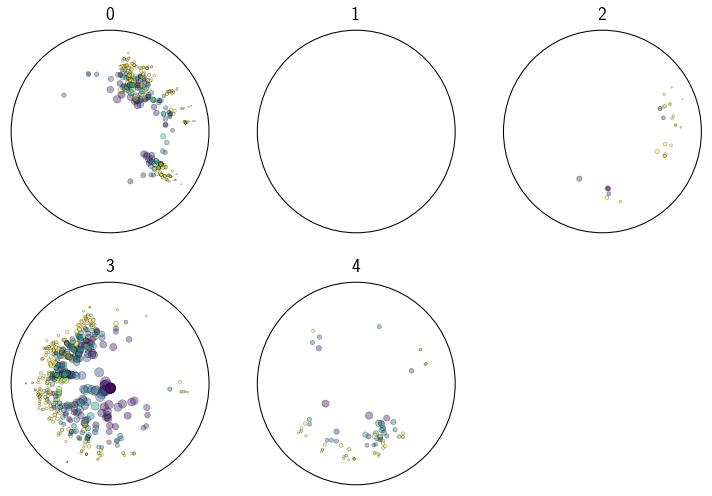

In [30]:
from matplotlib.patches import Circle


fig, axs = plt.subplots(2, 3, figsize=(12, 8))

df_features_S1_merged['x'] = df_features_S1_merged['inf_radius'] * np.cos(df_features_S1_merged['inf_theta'])
df_features_S1_merged['y'] = df_features_S1_merged['inf_radius'] * np.sin(df_features_S1_merged['inf_theta'])    

max_radius = df_features_S1_merged['inf_radius'].max()

i, j = 0, 0
for label in np.unique(df_labels['class']):
    tmp = df_features_S1_merged[df_features_S1_merged[label] > 0.5]
    axs[i, j].scatter(tmp['x'], tmp['y'],
                      s=10*np.log(tmp['inf_kappa'] + 1), c=tmp[label], 
                      edgecolors='black', alpha=0.4, linewidths=0.5, zorder=2)
    axs[i, j].set_title(label, fontsize=18)
    axs[i, j].axis('off')
    
    circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
    axs[i, j].add_patch(circle)
    axs[i, j].set_xlim(-max_radius-1, max_radius+1)
    axs[i, j].set_ylim(-max_radius-1, max_radius+1)
    
    j += 1
    if j == 3:
        i += 1
        j = 0


axs[1, 2].axis('off')
# axs[2, 2].axis('off')

In [32]:
df_features_S1_merged['class'] = df_features_S1_merged[np.unique(df_labels['class'])].idxmax(axis=1)
df_features_S1_merged

,index,inf_kappa,inf_theta,inf_radius,inf_kappa_le,inf_theta_le,inf_radius_le,0,2,3,4,1,x,y,class
0,f0,1.367900,1.17584,18.8615,1.23642,1.21878,19.2700,1.000000,0.000000,0.000000,0.000000,0.0,7.257299,17.409417,0
1,f1,0.552995,3.22419,20.6729,1.23642,3.21354,19.2700,0.000000,0.000000,1.000000,0.000000,0.0,-20.602421,-1.705586,3
2,f2,6.961270,5.66887,15.6074,6.54252,5.58437,15.9378,0.500000,0.000000,0.250000,0.250000,0.0,12.753872,-8.996092,0
3,f3,2.788170,0.60127,17.4373,2.81054,2.73035,17.6277,0.000000,0.500000,0.500000,0.000000,0.0,14.379109,9.864110,2
4,f4,18.585200,2.95413,13.6434,18.40570,3.01327,13.8691,0.000000,0.000000,0.666667,0.333333,0.0,-13.404371,2.542674,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,f1697,8.815370,5.42800,15.1351,8.64886,5.21415,15.3796,0.200000,0.000000,0.600000,0.200000,0.0,9.929816,-11.422347,3
1496,f1698,4.510200,5.64583,16.4754,4.58955,5.60864,16.6469,1.000000,0.000000,0.000000,0.000000,0.0,13.240823,-9.804050,0
1497,f1699,1.956160,2.73129,18.1461,2.81054,1.38972,17.6277,0.500000,0.000000,0.500000,0.000000,0.0,-16.639976,7.238241,0
1498,f1700,5.662720,2.99244,16.0203,6.54252,2.96129,15.9378,0.000000,0.000000,0.750000,0.250000,0.0,-15.842432,2.380621,3


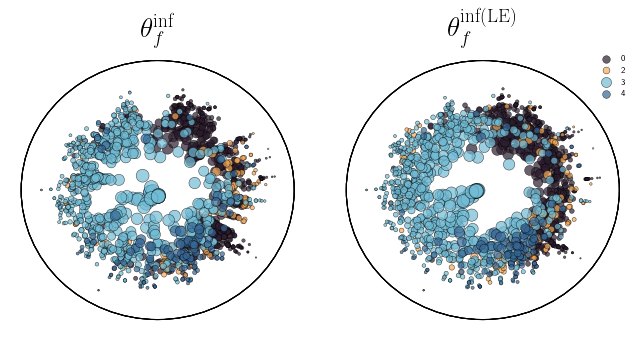

In [37]:
colormap = {label: color for color, label in zip(COLORS, np.unique(df_labels['class']))}

fig, axs = plt.subplots(1, 2, figsize=(9, 5))

for label, group in df_features_S1_merged.groupby('class'):
    group['x'] = group['inf_radius'] * np.cos(group['inf_theta'])
    group['y'] = group['inf_radius'] * np.sin(group['inf_theta'])    
    axs[0].scatter(group['x'], group['y'], s=20*np.log(group['inf_kappa'] + 1), label=label, color=colormap[label], 
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)
    circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
    axs[0].add_patch(circle)
    
    group['x'] = group['inf_radius'] * np.cos(group['inf_theta_le'])
    group['y'] = group['inf_radius'] * np.sin(group['inf_theta_le'])    
    axs[1].scatter(group['x'], group['y'], s=20*np.log(group['inf_kappa'] + 1), label=label, color=colormap[label], 
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)
    circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
    axs[1].add_patch(circle)
    
axs[0].set_title(r'$\theta_f^{\mathrm{inf}}$')
axs[1].set_title(r'$\theta_f^{\mathrm{inf(LE)}}$')
axs[0].axis('off')
axs[1].axis('off')
axs[1].legend(fontsize=8, frameon=False)

plt.tight_layout()
